In [122]:
import torch
from mirtorch.prox import prox
from mirtorch.linear import *
from mirtorch.alg import *
from mirtorch.alg.fista import FISTA
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, scale
import matplotlib.pyplot as plt
import matplotlib

In [164]:
#Binary classification on MNIST digits using FISTA (specifically 3 and 5)
#get dataset
try:
    X,y = X_orig, y_orig
except:
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

y = y.astype(np.float64)
X_orig, y_orig = X, y
print(len(X))
print(len(X[y==3]))
print(len(X[y==5]))
print(len(X[(y==3) | (y==5)]))

def show_digit(X, y):
    digit_image = X.reshape(28,28)
    print(f'Expected digit {y+4}')
    plt.imshow(digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

70000
7141
6313
13454


(13454, 784) (13454,)
Expected digit 5.0


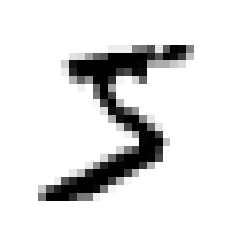

In [165]:
#reduce data to be binary classification for simplicity
X, y = X[(y==3) | (y==5)], y[(y==3) | (y==5)]
y = y - 4
print(X.shape, y.shape)
show_digit(X[0], y[0])
#create train/test sets
X = normalize(X, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=10000, test_size=3454)
X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test)

In [202]:
#define grad callable
X_train = X_train.type(torch.double)
X_test = X_test.type(torch.double)
y_train = y_train.type(torch.double)
y_test = y_test.type(torch.double)
def hubergrad(x, dh = .1):
    if x >= 1:
        return 0
    elif x < 1 and x > 1 - dh:
        return (x-1)/dh
    else:
        return -1
    
def diff_hubergrad(x, dh = .1):
    result = torch.where(x>=1, torch.tensor([0],dtype=torch.double), 
                         torch.where(x<=1-dh, torch.tensor([-1],dtype=torch.double), (x-1)/dh))
    return result

class A(LinearMap):
    def __init__(self, apply_y = True):
        self._A = X_train.clone()
        if apply_y:
            for i in range(self._A.shape[0]):
                self._A[i] *= y_train[i]
        
        super().__init__([28*28], [10000])
    def _apply(self, x):
        return torch.matmul(self._A, x)
    def _apply_adjoint(self, x):
        return torch.matmul(self._A.T, x)
        
class grad:
    def __init__(self, dh=.1, requires_grad=True):
        self.a = A()
        self.deltah = dh
        #self.L = 1/dh * torch.linalg.norm(self.a._A.T)**2
        self.requires_grad=requires_grad
        
    def __call__(self, x):
        x = self.a(x)
        # it is important that user defined function respects differential operations
        # these two implementations of the same function are different! I can call .backward() on one of them
        # and I can't on the other
        if self.requires_grad:
            x = diff_hubergrad(x)
        else:
            x = x.apply_(hubergrad)
        x = self.a.adjoint(x)
        return x
    
def eval(x):
    res = torch.matmul(X_test, x)
    res = torch.sign(res)
    res *= y_test
    total = res.shape[0]
    correct = res[res>0].shape[0]
    #print(f'\tCorrect {correct} out of {total} total')
    return correct, total

164 91


In [198]:
cgs = []
a_mat = A(apply_y=False)
grad_ = grad()
for i in range(1, 300, 5):
    #Run CG for i iterations
    cg = CG(A=a_mat.H*a_mat, max_iter=i).run(x0=torch.zeros(28*28, dtype=torch.double), b=a_mat.H(y_train))
    h = eval(cg)
    cgs.append(h[0]/h[1])

residual at 1th iter: 132899.01633197872
residual at 1th iter: 132899.01633197872
residual at 2th iter: 7416.3704902267045
residual at 3th iter: 2322.397186979142
residual at 4th iter: 953.0682927652231
residual at 5th iter: 395.4610425625441
residual at 6th iter: 323.7146307995424
residual at 1th iter: 132899.01633197872
residual at 2th iter: 7416.3704902267045
residual at 3th iter: 2322.397186979142
residual at 4th iter: 953.0682927652231
residual at 5th iter: 395.4610425625441
residual at 6th iter: 323.7146307995424
residual at 7th iter: 138.9719899363779
residual at 8th iter: 84.67156299966871
residual at 9th iter: 73.24482704533247
residual at 10th iter: 52.73123874455926
residual at 11th iter: 35.28970045639208
residual at 1th iter: 132899.01633197872
residual at 2th iter: 7416.3704902267045
residual at 3th iter: 2322.397186979142
residual at 4th iter: 953.0682927652231
residual at 5th iter: 395.4610425625441
residual at 6th iter: 323.7146307995424
residual at 7th iter: 138.97198

In [200]:
fsta =  []
grad_ = grad()
for i in range(1, 300, 5):
    #Run FISTA for i iterations
    L = 1/grad_.deltah * torch.linalg.norm(grad_.a._A, float('inf')) * torch.linalg.norm(grad_.a._A, 1)
    f = eval(FISTA(max_iter=i, fgrad=grad_, Lf=L, prox=prox.L1Regularizer(5e-5)).run_alg(x0=torch.zeros(28*28, dtype=torch.double)))
    fsta.append(f[0]/f[1])

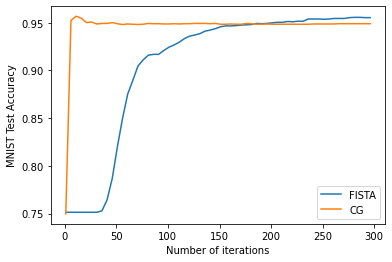

In [201]:
plt.plot([i for i in range(1, 300, 5)], fsta, label='FISTA')
plt.plot([i for i in range(1, 300, 5)], cgs, label='CG')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('MNIST Test Accuracy')
plt.show()

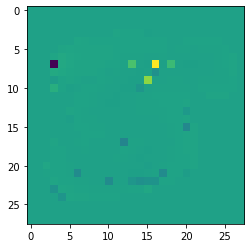

In [203]:
x = torch.zeros(28*28, dtype=torch.double, requires_grad=True)
res = FISTA(max_iter=100, fgrad=grad_, Lf=L, prox=prox.L1Regularizer(.001)).run_alg(x)
eval(res)
res.sum().backward() #can run .backward() on this
plt.imshow(x.grad.data.reshape(28,28).numpy())